In [1]:
# Install yfinance for market data
!pip install yfinance --quiet
print("Libraries installed successfully!")

Libraries installed successfully!


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style for professional look
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported.")

Libraries imported.


In [11]:
class AlgoStrategy:
    def __init__(self, ticker, start_date, end_date, initial_capital=10000):
        self.ticker = ticker
        self.start = start_date
        self.end = end_date
        self.capital = initial_capital
        self.data = None

    def fetch_data(self):
        """Fetches historical data from Yahoo Finance"""
        print(f"Fetching data for {self.ticker}...")
        # Explicitly set auto_adjust=False to ensure 'Adj Close' is present
        self.data = yf.download(self.ticker, start=self.start, end=self.end, progress=False, auto_adjust=False)
        self.data['Returns'] = self.data['Adj Close'].pct_change()
        self.data.dropna(inplace=True)

    def add_indicators(self):
        """Adds technical indicators for strategies"""
        # Strategy 1: Simple Moving Averages (Trend Following)
        self.data['SMA_50'] = self.data['Adj Close'].rolling(window=50).mean()
        self.data['SMA_200'] = self.data['Adj Close'].rolling(window=200).mean()

        # Strategy 2: Bollinger Bands (Mean Reversion / Volatility)
        self.data['Rolling_Mean'] = self.data['Adj Close'].rolling(window=20).mean()
        self.data['Rolling_Std'] = self.data['Adj Close'].rolling(window=20).std()
        self.data['Upper_Band'] = self.data['Rolling_Mean'] + (2 * self.data['Rolling_Std'])
        self.data['Lower_Band'] = self.data['Rolling_Mean'] - (2 * self.data['Rolling_Std'])

        self.data.dropna(inplace=True)

    def run_backtest(self, strategy_type='trend'):
        """
        Executes the backtest logic based on strategy type.
        strategy_type: 'trend' (SMA Crossover) or 'mean_reversion' (Bollinger Bands)
        """
        if strategy_type == 'trend':
            # 1 when 50 > 200 (Buy), 0 otherwise (Sell/Cash)
            self.data.loc[:, 'Signal'] = np.where(self.data['SMA_50'] > self.data['SMA_200'], 1, 0)

        elif strategy_type == 'mean_reversion':
            # Buy when price < Lower Band, Sell when price > Upper Band
            self.data.loc[:, 'Signal'] = 0
            # Create conditions
            buy_signal = self.data['Adj Close'] < self.data['Lower_Band']
            sell_signal = self.data['Adj Close'] > self.data['Upper_Band']

            # Vectorized logic for Mean Reversion is complex; simplified version:
            # We hold the position (1) if we dipped below lower band, until we hit upper band.
            # Ideally requires loop, but using forward fill for simplicity in this demo.
            signals = np.zeros(len(self.data))
            position = 0

            for i in range(len(self.data)):
                if buy_signal.iloc[i]:
                    position = 1
                elif sell_signal.iloc[i]:
                    position = 0
                signals[i] = position

            self.data.loc[:, 'Signal'] = signals

        # Calculate Strategy Returns
        # We shift signal by 1 because we trade on the NEXT day's open based on TODAY's close
        temp_strategy_returns = self.data['Signal'].shift(1) * self.data['Returns']
        # Fill NaN from shifting with 0, as no return occurred on the first shifted day
        self.data.loc[:, 'Strategy_Returns'] = temp_strategy_returns.fillna(0)

        # Calculate Equity Curve
        self.data.loc[:, 'Equity_Curve'] = self.capital * (1 + self.data['Strategy_Returns']).cumprod()

        return self.data

In [4]:
def performance_attribution(data, risk_free_rate=0.04):
    """Calculates key risk/return metrics"""

    # 1. Cumulative Return
    total_return = (data['Equity_Curve'].iloc[-1] / data['Equity_Curve'].iloc[0]) - 1

    # 2. Annualized Sharpe Ratio
    # Daily risk free rate approx
    daily_rf = risk_free_rate / 252
    excess_returns = data['Strategy_Returns'] - daily_rf
    sharpe_ratio = np.sqrt(252) * (excess_returns.mean() / excess_returns.std())

    # 3. Max Drawdown
    cumulative_returns = (1 + data['Strategy_Returns']).cumprod()
    peak = cumulative_returns.cummax()
    drawdown = (cumulative_returns - peak) / peak
    max_drawdown = drawdown.min()

    print(f"--- Performance Report ---")
    print(f"Total Return: {total_return:.2%}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(data['Equity_Curve'], label='Strategy Equity')
    plt.plot(data['Adj Close'] / data['Adj Close'].iloc[0] * data['Equity_Curve'].iloc[0], label='Buy & Hold (Benchmark)', alpha=0.5)
    plt.title("Strategy Performance vs Benchmark")
    plt.legend()
    plt.show()

    return max_drawdown

In [13]:
def monte_carlo_simulation(data, simulations=1000, days_projection=252):
    """
    Runs Monte Carlo simulation by shuffling historical returns
    to create 1000 alternative future realities.
    """
    returns = data['Strategy_Returns'].dropna()
    last_equity = data['Equity_Curve'].iloc[-1]

    simulation_results = []

    # Only plot if we are not suppressing output for calculation
    if simulations > 0:
        plt.figure(figsize=(10,6))

    for x in range(simulations):
        # Bootstrap: Random sampling with replacement
        daily_vol = returns.std()
        daily_drift = returns.mean()

        # Generating random path based on strategy's mean and std dev
        # Formula: Last_Price * exp(drift + vol * Z)
        price_series = [last_equity]

        for y in range(days_projection):
            shock = daily_drift + daily_vol * np.random.normal()
            price = price_series[-1] * (1 + shock)
            price_series.append(price)

        simulation_results.append(price_series[-1])
        if simulations > 0: # Only plot if we are not suppressing output for calculation
            plt.plot(price_series, alpha=0.05, color='green')

    if simulations > 0: # Only plot if we are not suppressing output for calculation
        plt.title(f"Monte Carlo Simulation: {simulations} Scenarios for Next Year")
        plt.xlabel("Days")
        plt.ylabel("Equity")
        plt.show()

        # Histogram of outcomes
        plt.figure(figsize=(10,6))
        plt.hist(simulation_results, bins=50, color='skyblue', edgecolor='black')
        plt.axvline(last_equity, color='r', linestyle='dashed', linewidth=2, label="Current Equity")
        plt.title("Distribution of Projected Equity (1 Year)")
        plt.legend()
        plt.show()

    return simulation_results, last_equity

Fetching data for SPY...
Running Trend Following Strategy...
--- Performance Report ---
Total Return: 48.21%
Sharpe Ratio: 0.30
Max Drawdown: -33.72%


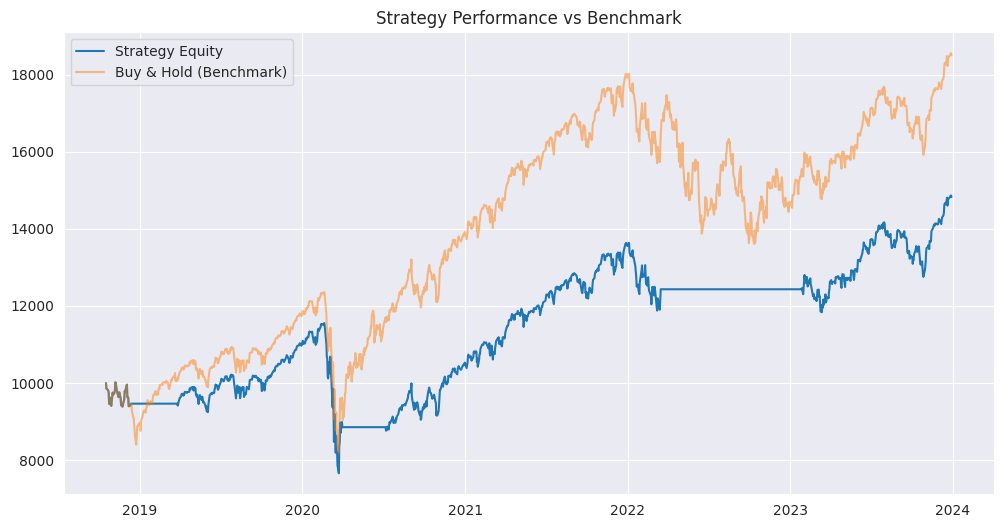

Running Monte Carlo Robustness Test...


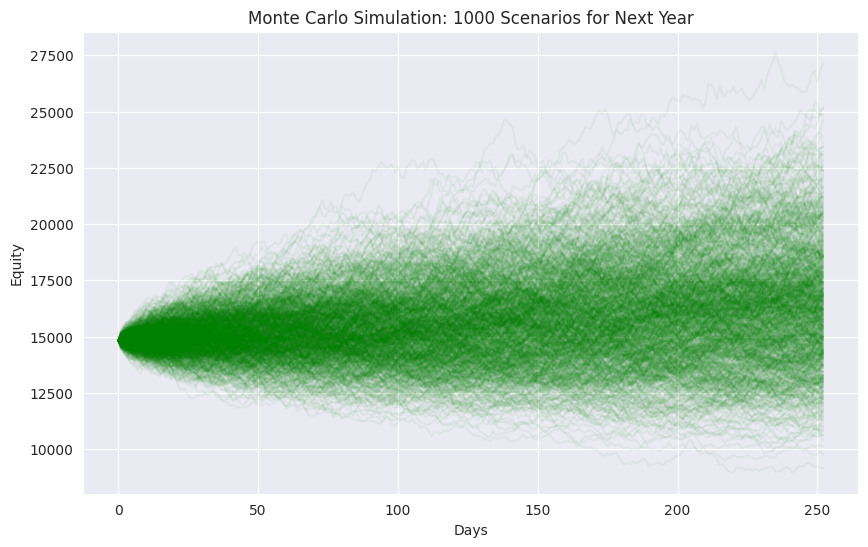

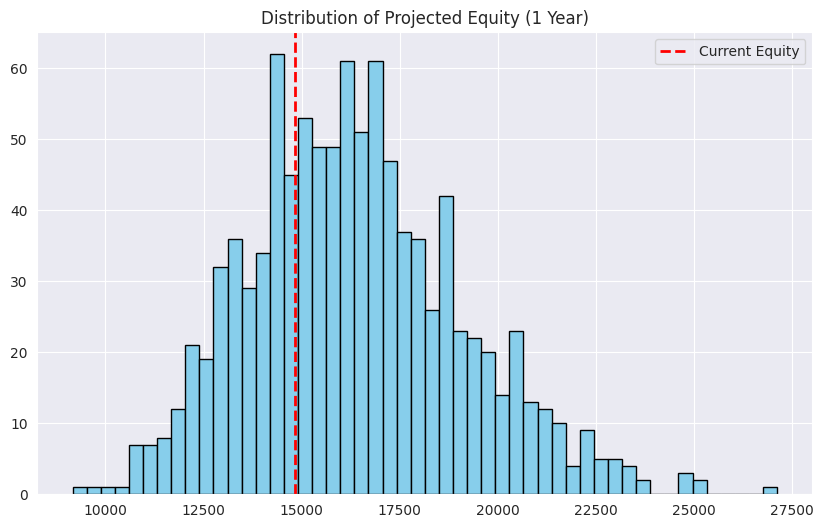

In [12]:
# 1. Initialize Strategy
# Let's use SPY (S&P 500 ETF) from 2018 to 2024
algo = AlgoStrategy(ticker='SPY', start_date='2018-01-01', end_date='2024-01-01')

# 2. Get Data & Indicators
algo.fetch_data()
algo.add_indicators()

# 3. Run Backtest (Try 'trend' or 'mean_reversion')
print("Running Trend Following Strategy...")
strategy_data = algo.run_backtest(strategy_type='trend')

# 4. Analyze Performance
performance_attribution(strategy_data)

# 5. Run Monte Carlo Simulation
print("Running Monte Carlo Robustness Test...")
monte_carlo_simulation(strategy_data)

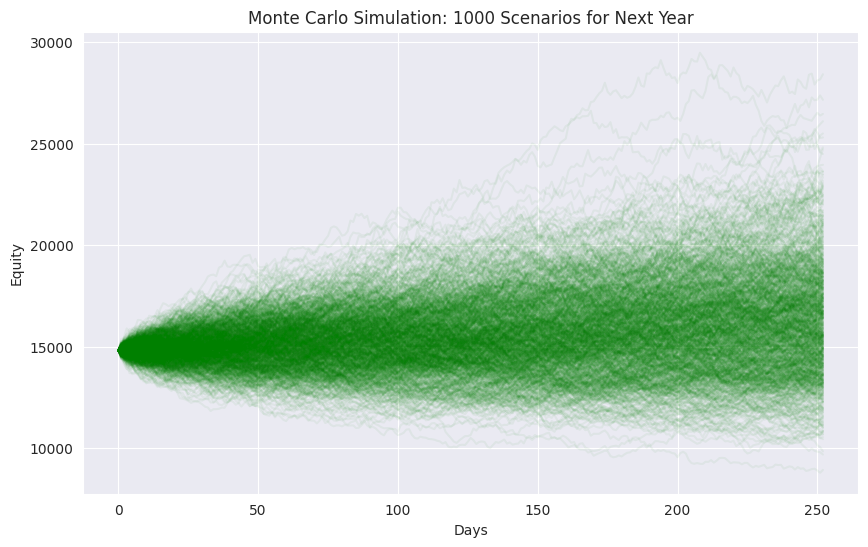

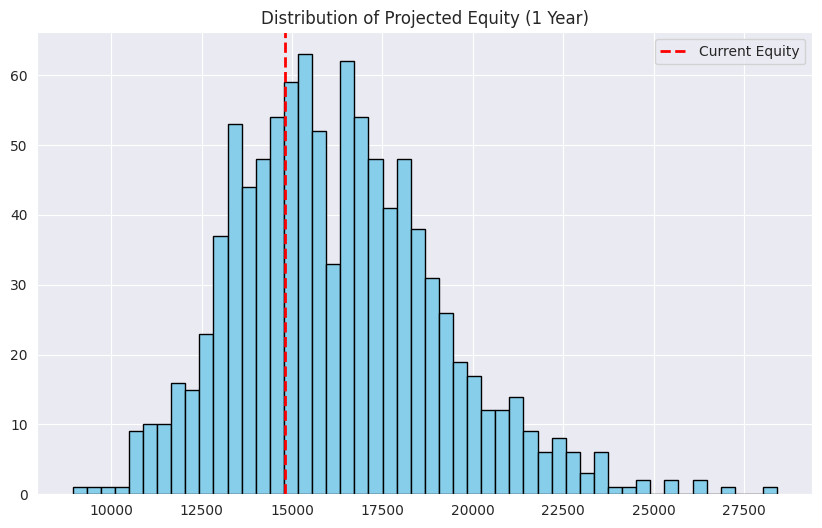

Average Projected Equity after 1 Year: $16,264.81
Average Projected Return after 1 Year: 9.74%


In [14]:
# Re-run Monte Carlo Simulation to get results
simulation_results, last_equity = monte_carlo_simulation(strategy_data, simulations=1000, days_projection=252)

# Calculate average projected equity and return
average_projected_equity = np.mean(simulation_results)
average_projected_return = (average_projected_equity / last_equity) - 1

print(f"Average Projected Equity after 1 Year: ${average_projected_equity:,.2f}")
print(f"Average Projected Return after 1 Year: {average_projected_return:.2%}")